In [1]:
import collections
import itertools
import json
import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm

In [2]:
with open("data/results/test_1M__post_stats.json") as handle:
    post_stats = json.load(handle)

with open("data/results/test_1M__pairs_first_dates.json") as handle:
    pairs_first_dates = json.load(handle)

with open("data/results/test_1M__pairs_count.json") as handle:
    pairs_count = json.load(handle)

with open("data/results/test_1M__user_to_posts.json") as handle:
    user_to_posts = json.load(handle)

In [3]:
# This may not be necessary as the input seems already sorted, but let us code this defensively.
sorted_post_stats = sorted(post_stats, key=lambda item:  datetime.datetime.strptime(item['date'], "%Y-%m-%dT%H:%M:%S.%f"))

In [4]:
VALUE_THRESHOLDS = 100

user_posts = collections.defaultdict(set)

novel_post_stats = []
post_rank_count = collections.defaultdict(int)
novel_post_rank_count = collections.defaultdict(int)
valuable_novel_post_rank_count = collections.defaultdict(int)

stats = collections.defaultdict(int)
for post_stat in tqdm.tqdm(sorted_post_stats):
    try:
        user_posts[post_stat["poster_id"]].add(post_stat["id"])
        post_rank = len(user_posts[post_stat["poster_id"]])
        novelty_count = 0
        is_valuable = False
        for imp1, imp2 in itertools.combinations(post_stat["imports"], 2):
            canonical_pair_name = "|".join(sorted([imp1, imp2]))
            if pairs_first_dates[canonical_pair_name]["id"] == post_stat["id"]:
                novelty_count += 1
                if pairs_count[canonical_pair_name] >= VALUE_THRESHOLD:
                    is_valuable = True
                novel_post_stats.append(
                    {
                        "poster_id": post_stat["poster_id"],
                        "id": post_stat["id"],
                        "current_post_count": len(user_posts[post_stat["poster_id"]]),
                        "canonical_pair_name": canonical_pair_name,
                        "pair_total_use": pairs_count[canonical_pair_name],
                    }
                )
        if novelty_count > 0:
            stats["novelty_post_count"] += 1
            novel_post_rank_count[post_rank] += 1
            if is_valuable:
                valuable_novel_post_rank_count[post_rank] += 1
        else:
            stats["non_novel_post_count"] += 1
        stats["total_post_count"] += 1
        post_rank_count[post_rank] += 1
    except Exception as exc:
        stats[exc] += 1
print(stats)

novel_ratio = {k: novel_post_rank_count.get(k, 0) / post_rank_count.get(k, 1) for k in sorted(valuable_novel_post_rank_count.keys())}
valuable_novel_ratio = {k: valuable_novel_post_rank_count.get(k, 0) / post_rank_count.get(k, 1) for k in sorted(valuable_novel_post_rank_count.keys())}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 187919/187919 [00:04<00:00, 40666.87it/s]

defaultdict(<class 'int'>, {NameError("name 'VALUE_THRESHOLD' is not defined"): 1, 'non_novel_post_count': 172828, 'total_post_count': 172828, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD' is not defined"): 1, NameError("name 'VALUE_THRESHOLD

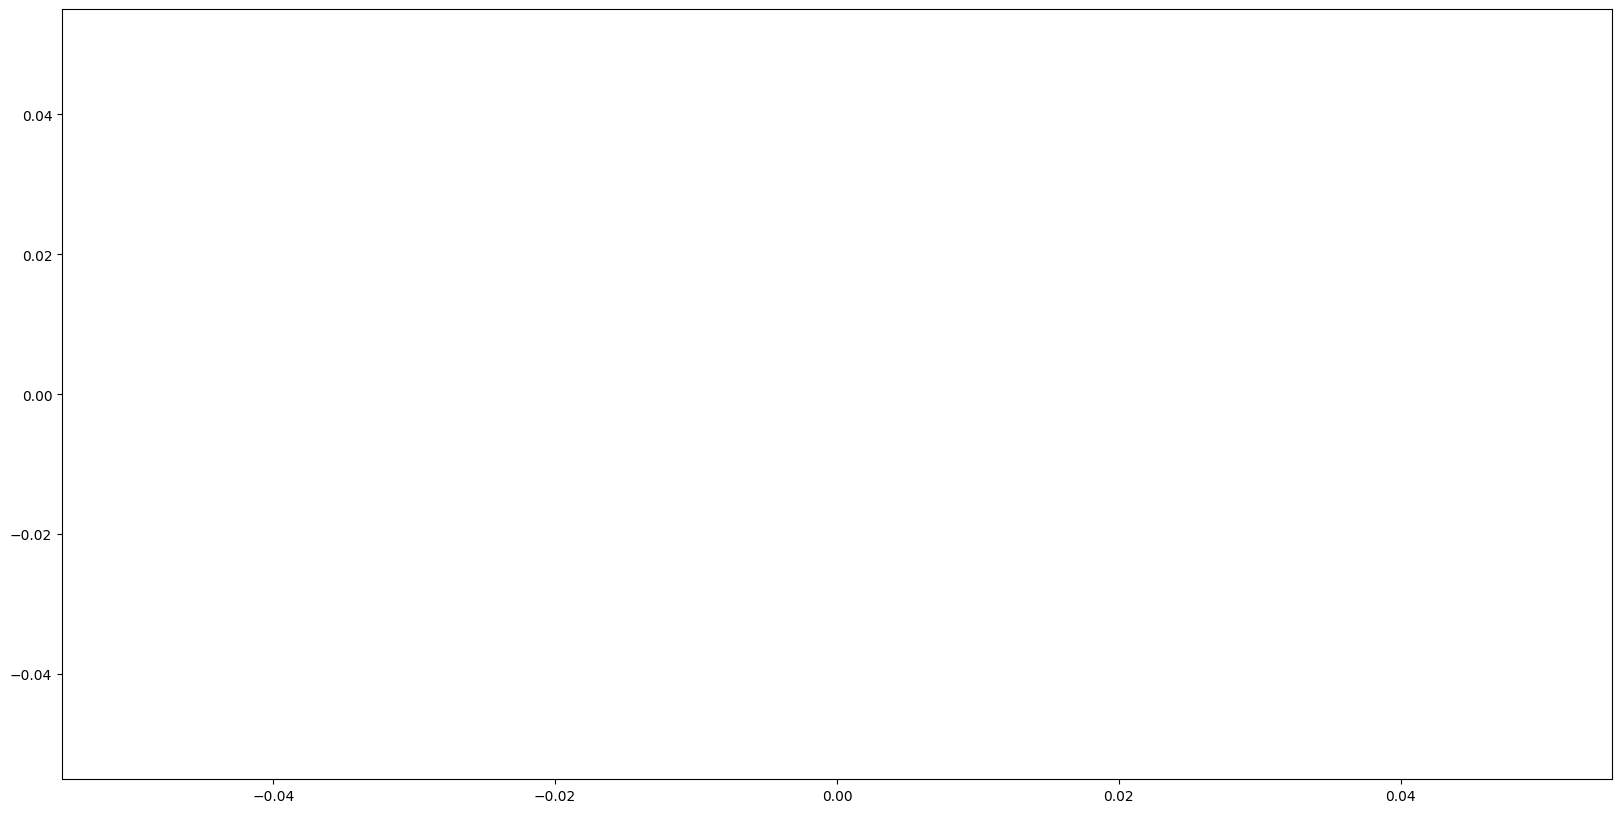

In [5]:
plt.figure(figsize=(20,10))
plt.plot(sorted(novel_ratio.keys()), [novel_ratio[x] for x in sorted(novel_ratio.keys())], "b*")
plt.plot(sorted(valuable_novel_ratio.keys()), [valuable_novel_ratio[x] for x in sorted(valuable_novel_ratio.keys())], "r*")

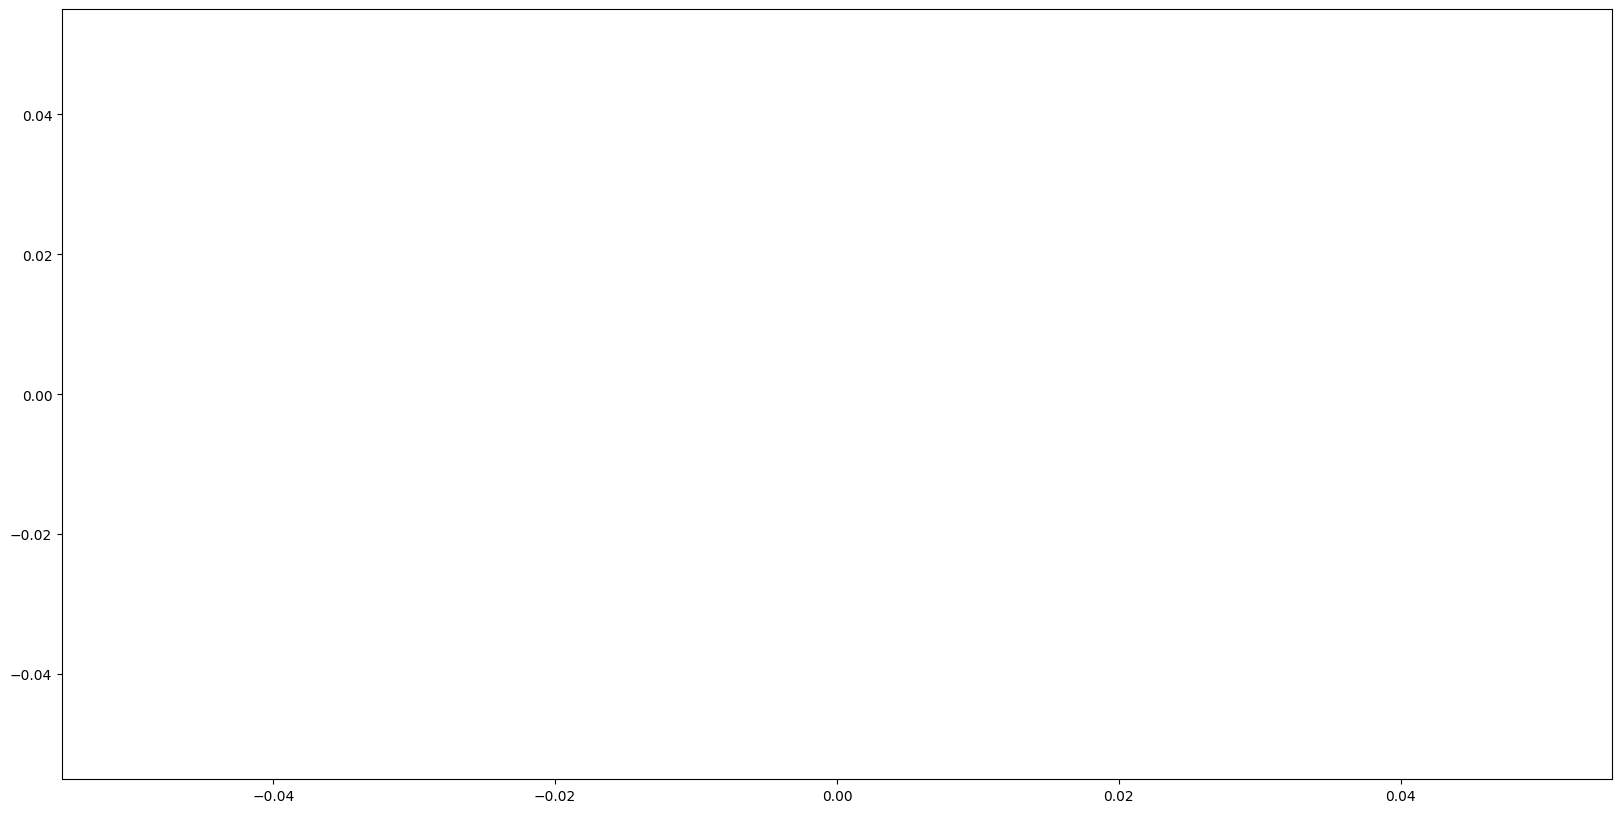

In [6]:
plt.figure(figsize=(20,10))
plt.plot(sorted(valuable_novel_ratio.keys()), [valuable_novel_ratio[x] for x in sorted(valuable_novel_ratio.keys())], "b*")

[]

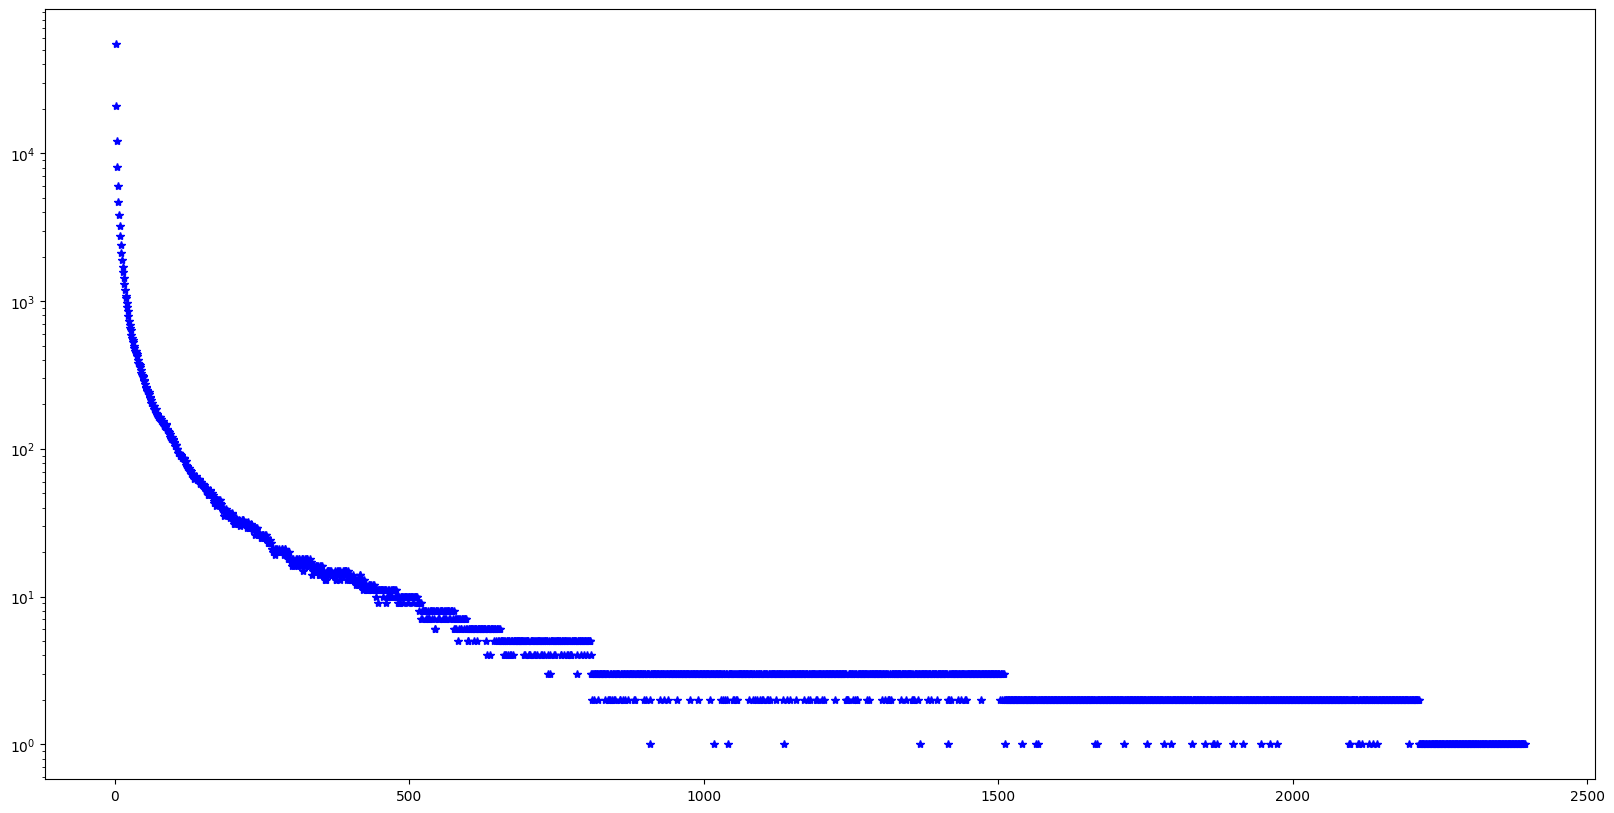

In [7]:
plt.figure(figsize=(20,10))
plt.plot(sorted(post_rank_count.keys()), [post_rank_count[x] for x in sorted(post_rank_count.keys())], "b*")
plt.semilogy()

In [8]:
impacts = pd.DataFrame(novel_post_stats);impacts

""


In [9]:
impacts["imp"] = impacts.groupby(["poster_id", "id", "current_post_count"])["pair_total_use"].transform(sum)

KeyError: 'poster_id'

In [ ]:
impacts

In [ ]:
def custom_bin(x):
    bin_borders = [1, 10, 50, 100, 500]   #[1, 5, 10, 20, 40, 100, 200, 500]
    for border in bin_borders:
        if x <= border:
            return f"<={border}"
    return "INF"

impacts["custom_bin"] = impacts.current_post_count.map(custom_bin)
impacts.groupby(["custom_bin"])["id"].count().plot.pie(autopct='%1.1f%%', startangle=0)

In [ ]:
# compare this with the post distribution among users using ALL posts.
u2p = pd.DataFrame({k: len(v) for k, v in user_to_posts.items()}.items(), columns=["user_id", "post_count"])
u2p["custom_bin"] = u2p.post_count.map(custom_bin)
u2p.groupby(["custom_bin"])["user_id"].count().plot.pie(autopct='%1.1f%%', startangle=0)

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=2)
impacts.groupby(["custom_bin"])["id"].count().plot.pie(autopct='%1.1f%%', startangle=0, ax = axes[:,0], subplots=True)
pd1.plot() 
pd2.plot(ax = axes[:,1], subplots=True)

In [ ]:
# Collect posts with High-enough impact and display the distribution of former post counts at the time of  posting the impactful post

impacts[impacts["pair_total_use"] > 100]["current_post_count"].hist(bins=200 ,log=True,figsize=(20,10))

# Post rank (per user) to probability of a) being novelty b) being impactful novelty. 